<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

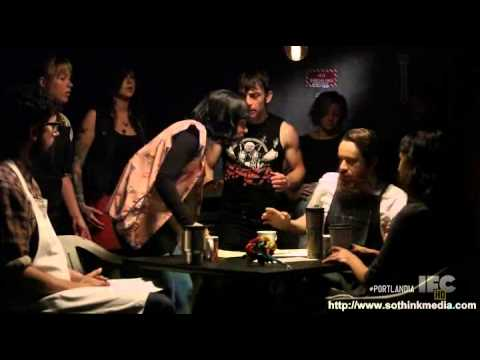

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\theta\\Desktop\\Lambda School\\DS6\\unit_4_sprint_1\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [123]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [124]:
shops.shape

(7616, 3)

In [125]:
# Inspect first review
shops['full_review_text'][0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [126]:
def clean(df):
    """Function to clean data for NLP analysis"""
    
    # Remove leading and trailing white space
    df['full_review_text'] = df['full_review_text'].apply(lambda x: x.strip())
    
    # Move dates in reviews to new column
    df['review_date'] = df['full_review_text'].apply(lambda x: x.split()[0])
    
    # Remove dates from review text
    df['full_review_text'] = df['full_review_text'].apply(lambda x: ' '.join(x.split()[1:]))
    
    # Add new column to show number of check-ins
    df['check_ins'] = df['full_review_text'].apply(lambda x: x.split()[0]
                                                  if x.split()[1] == 'check-in'
                                                  or x.split()[1] == 'check-ins'
                                                  else 0)
    
    # Remove check-ins from review text
    df['full_review_text'] = df['full_review_text'].apply(lambda x: ' '.join(x.split()[2:])
                                                         if x.split()[1] == 'check-in'
                                                         or x.split()[1] == 'check-ins'
                                                         else x)
    
    # Convert review text to lowercase
    df['full_review_text'] = df['full_review_text'].apply(lambda x: x.lower())
    
    # Remove text from star rating and convert rating to int
    df['star_rating'] = df['star_rating'].apply(lambda x: x.split('.')[0]).astype('int')
    
    return df

In [127]:
shops = clean(shops)
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,check_ins
0,The Factory - Cafe With a Soul,love love loved the atmosphere! every corner o...,5,11/25/2016,1
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",4,12/2/2016,0
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,4,11/30/2016,1
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating howe...,2,11/25/2016,0
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,4,12/3/2016,1


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [128]:
shops['star_rating'] = shops['star_rating'].replace({1:'bad', 2:'bad', 3:'bad', 4:'good', 5:'good'})
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,check_ins
0,The Factory - Cafe With a Soul,love love loved the atmosphere! every corner o...,good,11/25/2016,1
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",good,12/2/2016,0
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,good,11/30/2016,1
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating howe...,bad,11/25/2016,0
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,good,12/3/2016,1


In [129]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load('en_core_web_lg')
tokenizer = Tokenizer(nlp.vocab)

In [131]:
# Add words to stop words list
nlp.vocab['shop'].is_stop = True
nlp.vocab['listed'].is_stop = True
print(nlp.vocab['shop'].is_stop)
print(nlp.vocab['listed'].is_stop)

True
True


In [132]:
# Tokenizer pipe
tokens = []

for doc in nlp.pipe(shops['full_review_text']):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
            
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [133]:
shops.shape

(7616, 6)

In [134]:
# Run lemmatization on the tokens
shops['lemmas'] = shops['full_review_text'].apply(lambda text:
                                                 [x.lemma_ for x in nlp(text.lower())
                                                 if (x.is_stop == False and x.is_punct == False)
                                                 and x.pos_ != "-PRON-"])

In [135]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,check_ins,tokens,lemmas
0,The Factory - Cafe With a Soul,love love loved the atmosphere! every corner o...,good,11/25/2016,1,"[love, love, loved, atmosphere, corner, coffee...","[love, love, love, atmosphere, corner, coffee,..."
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",good,12/2/2016,0,"[date, night, austin, ambiance, austin, beauti...","[date, night, austin, ambiance, austin, beauti..."
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,good,11/30/2016,1,"[brunch, spots, loved, eclectic, homey, plush,...","[brunch, spot, love, eclectic, homey, plush, d..."
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating howe...,bad,11/25/2016,0,"[cool, decor, good, drinks, nice, seating, ove...","[cool, decor, good, drink, nice, seating, over..."
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,good,12/3/2016,1,"[located, northcross, mall, shopping, center, ...","[locate, northcross, mall, shopping, center, f..."


In [136]:
from collections import Counter

def count(docs):
    """Function to find word counts within a document"""
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [137]:
wc = count(shops['lemmas'])

In [138]:
wc.tail(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
14503,4people,1,1,14509.0,0.000003,0.999974,0.000131
14509,uneventful,1,1,14510.0,0.000003,0.999977,0.000131
14507,fried,1,1,14511.0,0.000003,0.999980,0.000131
14508,tasted,1,1,14512.0,0.000003,0.999983,0.000131
14511,romaine,1,1,14513.0,0.000003,0.999986,0.000131
14512,predictably,1,1,14514.0,0.000003,0.999989,0.000131
14513,windowed,1,1,14515.0,0.000003,0.999991,0.000131
14515,actuality,1,1,14516.0,0.000003,0.999994,0.000131
14514,crass,1,1,14517.0,0.000003,0.999997,0.000131
14516,digestion,1,1,14518.0,0.000003,1.000000,0.000131


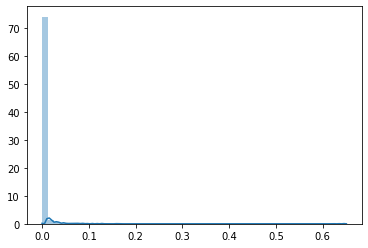

In [140]:
import numpy as np
import seaborn as sns

# Frequency of appears in documents
sns.distplot(np.array(wc['appears_in_pct']));

In [141]:
wc['appears_in_pct'].describe()

count    14518.000000
mean         0.002678
std          0.014356
min          0.000131
25%          0.000131
50%          0.000263
75%          0.000788
max          0.650341
Name: appears_in_pct, dtype: float64

In [142]:
wc.shape

(14518, 7)

In [143]:
# Statistical trimming
wc = wc[wc['appears_in_pct'] >= 0.0025]
wc.shape

(1878, 7)

In [144]:
wc.sort_values(by='appears_in', ascending=False).tail()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
4619,beard,20,25,1730.0,0.000071,0.870029,0.002626
4611,hibiscus,20,25,1729.0,0.000071,0.869958,0.002626
3536,farmer,20,21,1892.0,0.000060,0.880422,0.002626
3633,collection,20,21,1893.0,0.000060,0.880482,0.002626
8884,bed,20,20,1969.0,0.000057,0.884835,0.002626


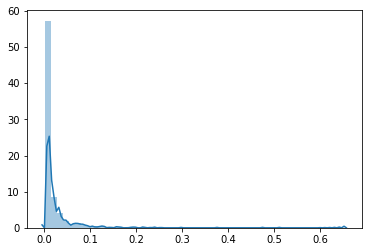

In [146]:
sns.distplot(np.array(wc['appears_in_pct']));

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
import squarify

In [148]:
# top 20 words found in reviews
top_20 = wc[wc['rank'] <= 20]

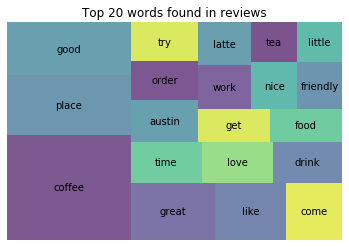

In [149]:
# Visualize top 20 words
squarify.plot(sizes=top_20['pct_total'], label=top_20['word'], alpha=0.7)
plt.title('Top 20 words found in reviews')
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [153]:
# Separate good reviews from bad reviews
good_wc = count(shops[shops['star_rating'] == 'good']['lemmas'])
bad_wc = count(shops[shops['star_rating'] == 'bad']['lemmas'])

In [154]:
# Get top 10 words used in good reviews
good_wc_10 = good_wc[good_wc['rank'] <= 10]

# Get top 10 words used in bad reviews
bad_wc_10 = bad_wc[bad_wc['rank'] <= 10]

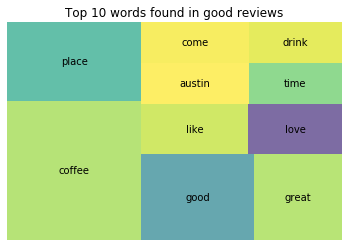

In [155]:
# Plot top 10 words for good reviews
squarify.plot(sizes=good_wc_10['pct_total'], label=good_wc_10['word'], alpha=0.7)
plt.title('Top 10 words found in good reviews')
plt.axis('off')
plt.show()

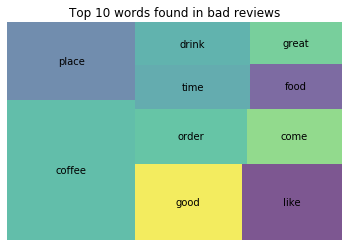

In [156]:
# Plot top 10 words for bad reviews
squarify.plot(sizes=bad_wc_10['pct_total'], label=bad_wc_10['word'], alpha=0.7)
plt.title('Top 10 words found in bad reviews')
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

